## HW 2
* Ask the user to supply the mean and standard deviation of a 1D Gaussian


* For the given mean and std, draw 1,000,000 random samples from the 1D Gaussian 


* Build a dataset 𝒟 with 1,000 histogram bins 


* Split the dataset into train (90%) and test (10%): 𝒟={𝒟_𝑡𝑟𝑎𝑖𝑛,𝒟_𝑡𝑒𝑠𝑡 }. Make sure both train and test are IID.


* Using pure Python3 and Numpy, build a 3-layer neural networks: 


* Layers: {1−64−𝑅𝑒𝐿𝑈−64−𝑅𝑒𝐿𝑈−64−1−𝑠𝑖𝑔𝑚𝑜𝑖𝑑}  . Sigmoid is optional.


* Initialize the weights using a Gaussian distribution with zero mean and std=0.01


* Using pure Python3 and Numpy, implement the backpropagation discussed in this class. Learning rate=0.1. Batch size =1. Loss=MSE.


* Train for 20 epochs and evaluate the performance of your network

So first, let us get the mean and standard deviation from the user.

In [1]:
mean = input("Give mean: ")
mean = float(mean)
print(mean)
std = input("Give standard dev: ")
std = float(std)
print(std)

Give mean: 0
0.0
Give standard dev: 1
1.0


In this example, we get a mean of 0 and standard deviation of 1

In [2]:
import numpy as np

#Set a random seed so that results are reproducible
np.random.seed(24)


# Create our 1D Gaussian using our mean and std from user with 1,000,000 datapoints
gauss_data = np.random.normal(mean, std, size=1000000)
print("Num of datapoints:",len(gauss_data))
print("Mean:",gauss_data.mean() )
print("Standard Deviation:",gauss_data.std() )

Num of datapoints: 1000000
Mean: -0.0005503085198210411
Standard Deviation: 1.0000568214672916


We use np.random.normal to create a normal distribution with the given mean and standard deviation.

* Build a dataset 𝒟 with 1,000 histogram bins 


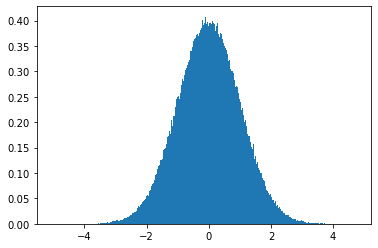

In [3]:
import matplotlib.pyplot as plt

# We get the values from our histogram plot so that we know the frequency of each bin
# We set bins = 1000 because we only want 1000 samples from our dataset

counts, bins, bars = plt.hist(gauss_data, density = True, bins= 1000)

From the plot above, we see that the data is truly a normal distribution.

In [4]:
D_x = bins[:1000] #Values
D_y = counts #Frequency

In [5]:
len(D_x)

1000

In [6]:
len(D_y)

1000

* Split the dataset into train (90%) and test (10%): 𝒟={𝒟_𝑡𝑟𝑎𝑖𝑛,𝒟_𝑡𝑒𝑠𝑡 }. Make sure both train and test are IID.


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(D_x, D_y, test_size=0.1, random_state = 12)


Note that we only used the sklearn library to create our train/test split, since the instructions were to use pure Python and Numpy in implementing the neural network and backpropagation. 

We want to make sure that the test and train splits are IID, so we implement a KS test to check whether this holds true.

In [8]:
from scipy.stats import ks_2samp

ks_2samp(X_train, X_test)

KstestResult(statistic=0.06333333333333334, pvalue=0.8454854163038065)

In [9]:
ks_2samp(y_train, y_test)

KstestResult(statistic=0.07111111111111111, pvalue=0.7315282656781205)

Since our p-values are high (> 0.05), it is probable that the D_test and D_train are IID

* Using pure Python3 and Numpy, build a 3-layer neural networks: 


* Layers: {1−64−𝑅𝑒𝐿𝑈−64−𝑅𝑒𝐿𝑈−64−1−𝑠𝑖𝑔𝑚𝑜𝑖𝑑}  . Sigmoid is optional.


* Initialize the weights using a Gaussian distribution with zero mean and std=0.01


* Using pure Python3 and Numpy, implement the backpropagation discussed in this class. Learning rate=0.1. Batch size =1. Loss=MSE.

The first thing that we will do is to create our activation functions. These activation functions specifically, are the ReLU and the sigmoid functions. Activation functions add non-linearity to our neural networks, else they would just be cominbations of linear functions. Note that we also need to prepare their derivatives for implementation of the forward propagation and backpropagation.

![image info](https://www.researchgate.net/profile/Knut_Kvaal/publication/239269767/figure/fig2/AS:643520205430784@1530438581076/An-illustration-of-the-signal-processing-in-a-sigmoid-function.png)

![image info](https://miro.medium.com/max/1000/1*3JUMOqugWKB2SDra6x6v0A.png)

In [10]:
def sigmoid(Z):
    return 1 / (1+ np.exp(-Z))

def sigmoid_prime(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu(Z):
    return np.maximum(Z, 0)

def relu_prime(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

Next, we will implement our weight initialization. It is important to initalize our weights so that the outputs from our activation layers that we implemented above do not explode our vanish during the forward pass a deep neural network. If either occurs, then loss gradients will be to small or too large for the backpropagation. Thus, it will take longer to converge or perhaps never converge at all.

In [11]:
def init_layers(nn_architecture, seed = 24):
    # We set our random seed for reproducibility
    np.random.seed(seed)
    
    
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
# Initialize the weights using a Gaussian distribution with zero mean and std=0.01
        params_values['W' + str(layer_idx)] = np.random.normal(0, 0.01, size = (layer_output_size, layer_input_size) )
        params_values['b' + str(layer_idx)] = np.zeros((layer_output_size, 1) ) 
        
    return params_values


Before we can implement our backpropagation, we need to first implement our forward pass. Our input data is fed forward through the network. Each hidden layer accepts this input data, processes it according to the activation function and passes it on to the next successive layer. 

![image info](https://miro.medium.com/max/596/1*tp73P0isrrfpj8RG-5aH6w.png)

In [12]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # Pick which implemented activation function to use
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid

    return activation_func(Z_curr), Z_curr

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-12-dda81e0202a9>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
<ipython-input-12-dda81e0202a9>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":


In [13]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    # Layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        activ_function_curr = layer["activation"] #Activation function for current layer
        
        W_curr = params_values["W" + str(layer_idx)] #Weights for current layer
        b_curr = params_values["b" + str(layer_idx)] #Biases for current layer
        
        #Application of function above given the current weights, biases, and activation function
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

* Using pure Python3 and Numpy, implement the backpropagation discussed in this class. Learning rate=0.1. Batch size =1. Loss=MSE.

First let's create our loss function which should be MSE

The loss function is what gives us a sense of how good our model is. It is used to evaluate our model's performance. MSE stands for Mean Squared Error, and it is calculated as the average of the squared differences between the predicted and actual values. Thus, its output is always a positive value.

![image info](https://i.imgur.com/vB3UAiH.jpeg)

In [14]:
def loss(pred, actual):
    """MSE loss function"""
    return np.mean((actual - pred)**2)

Now, we implement our backpropagation. Backpropagation is a way of propagating the total loss back into the neural network to calculate how much of the loss each node is responsible for. This way, each node can update its weights in such a way to minimize the overall loss of the network. It does this by computing for the gradient of the loss function with respect to the weights of the network.

![image info](https://images.deepai.org/glossary-terms/73eec54be08746f6b546a874580b8673/backpropagation.png)

In [15]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    m = A_prev.shape[1]
    
    # Picking activation function by using its derivative
    if activation is "relu":
        backward_activation_func = relu_prime
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_prime

    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the weights
    dW_curr = np.dot(dZ_curr, A_prev.T) 
    # derivative of the bias
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) 
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-15-3630d76793d4>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
<ipython-input-15-3630d76793d4>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":


In [16]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    # since we're using MSE
    dA_prev = (Y_hat - Y) * 2
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

The next part is simply updating our weights and biases

In [17]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

Lastly, we create our training function to apply all of the functions we've implemented so far. The training process will look similar to the picture below.


![image info](https://www.researchgate.net/publication/327870314/figure/fig1/AS:674797562363914@1537895684936/Flow-chart-of-the-neural-network-training-process.png)

In [18]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    
    # performing calculations for subsequent iterations
    for num in range(epochs):
        # step forward
        for i in range(len(X)): #So that batch size = 1
            Y_hat, cashe = full_forward_propagation(X[:, i:i+1], params_values, nn_architecture)

            # calculating metrics and saving them in history
            cost = loss(Y_hat, Y[:,i:i+1])
            cost_history.append(cost)


            # step backward - calculating gradient
            grads_values = full_backward_propagation(Y_hat, Y[:,i:i+1], cashe, params_values, nn_architecture)
            # updating model state
            params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        if(num % 1 == 0):
            print("Iteration: {:05} - cost: {:.8f}".format(num, cost))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

In [19]:
# Based on instructions
nn_archi = [
    {"input_dim": 1, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 1, "activation": "sigmoid"}
]

In [20]:
# Just to fix the dimensions

X_train = X_train.reshape((1, 900))
y_train = y_train.reshape((1, 900))

X_test = X_test.reshape((1, 100))
y_test = y_test.reshape((1, 100))

In [21]:
# Based on given specs
weights = train(X_train, y_train, nn_archi, epochs=20, learning_rate=0.1)


Iteration: 00000 - cost: 0.24968170
Iteration: 00001 - cost: 0.24346060
Iteration: 00002 - cost: 0.23739881
Iteration: 00003 - cost: 0.23149434
Iteration: 00004 - cost: 0.22574877
Iteration: 00005 - cost: 0.22015880
Iteration: 00006 - cost: 0.21472249
Iteration: 00007 - cost: 0.20943770
Iteration: 00008 - cost: 0.20430325
Iteration: 00009 - cost: 0.19931599
Iteration: 00010 - cost: 0.19447282
Iteration: 00011 - cost: 0.18977073
Iteration: 00012 - cost: 0.18520682
Iteration: 00013 - cost: 0.18077816
Iteration: 00014 - cost: 0.17648166
Iteration: 00015 - cost: 0.17231399
Iteration: 00016 - cost: 0.16827193
Iteration: 00017 - cost: 0.16435216
Iteration: 00018 - cost: 0.16055140
Iteration: 00019 - cost: 0.15686632


Now let's try to evaluate how our model would perform on its unseen data, which is our Test data split

In [22]:
# We do this by running our full forward propagation on our test dataset and storing its predictions
test_pred, mem = full_forward_propagation(X_test, weights, nn_archi)


In [23]:
test_pred.shape

(1, 100)

In [24]:
# We reshape for plotting purposes
X_test = X_test.reshape((100, 1))
y_test = y_test.reshape((100, 1))

test_pred = test_pred.reshape((100, 1))

In [25]:
test_pred.shape

(100, 1)

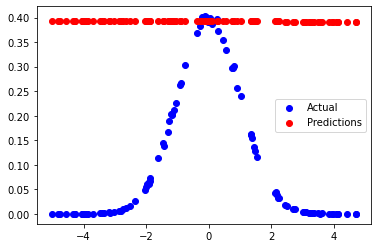

In [26]:
plt.scatter(X_test, y_test, color = 'blue', label = 'Actual')
plt.scatter(X_test, test_pred, color = 'red', label = 'Predictions')
plt.legend()
plt.show()

The plot above shows how our model runs on the test data. As you can see it doesn't perform very well yet. However, tweaking our model can result in massive boosts to its performance. For example, changing the std at initialization from 0.01 to 0.3 results in a much better model. We can also try testing out different learning rates to get better results. Another thing we can do is to run more epochs. Since we're only running 20 epochs, the model actually trains very quickly so it might be a good idea to have a trade-off of more time spent training, for a better performing model.

Next cell is just to test out changing our initialization

In [30]:
def init_layers(nn_architecture, seed = 24):
    # We set our random seed for reproducibility
    np.random.seed(seed)
    
    
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
# Initialize the weights using a Gaussian distribution with zero mean and std=0.01
        params_values['W' + str(layer_idx)] = np.random.normal(0, 0.3, size = (layer_output_size, layer_input_size) )
        params_values['b' + str(layer_idx)] = np.zeros((layer_output_size, 1) ) 
        
    return params_values


In [31]:
# Just to fix the dimensions

X_train = X_train.reshape((1, 900))
y_train = y_train.reshape((1, 900))

X_test = X_test.reshape((1, 100))
y_test = y_test.reshape((1, 100))

# Based on given specs
weights = train(X_train, y_train, nn_archi, epochs=20, learning_rate=0.1)

# We do this by running our full forward propagation on our test dataset and storing its predictions
test_pred, mem = full_forward_propagation(X_test, weights, nn_archi)

# We reshape for plotting purposes
X_test = X_test.reshape((100, 1))
y_test = y_test.reshape((100, 1))

test_pred = test_pred.reshape((100, 1))

Iteration: 00000 - cost: 0.04829806
Iteration: 00001 - cost: 0.00029748
Iteration: 00002 - cost: 0.00028494
Iteration: 00003 - cost: 0.00027341
Iteration: 00004 - cost: 0.00026276
Iteration: 00005 - cost: 0.00025290
Iteration: 00006 - cost: 0.00024375
Iteration: 00007 - cost: 0.00023522
Iteration: 00008 - cost: 0.00022726
Iteration: 00009 - cost: 0.00021982
Iteration: 00010 - cost: 0.00021283
Iteration: 00011 - cost: 0.00020628
Iteration: 00012 - cost: 0.00020011
Iteration: 00013 - cost: 0.00019429
Iteration: 00014 - cost: 0.00018879
Iteration: 00015 - cost: 0.00018359
Iteration: 00016 - cost: 0.00017867
Iteration: 00017 - cost: 0.00017400
Iteration: 00018 - cost: 0.00016956
Iteration: 00019 - cost: 0.00016534


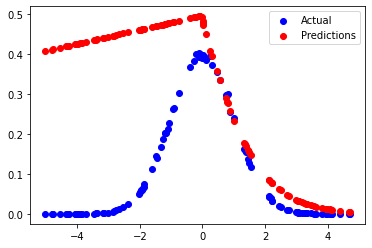

In [32]:
plt.scatter(X_test, y_test, color = 'blue', label = 'Actual')
plt.scatter(X_test, test_pred, color = 'red', label = 'Predictions')
plt.legend()
plt.show()

As shown by the plot above, initialization is very crucial to how the model will perform. Even though we used the same number of epochs, the performance was much better.

## References:
- https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb (Main Source of code)
- https://www.freecodecamp.org/news/building-a-3-layer-neural-network-from-scratch-99239c4af5d3/
- https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
- https://towardsdatascience.com/forward-propagation-in-neural-networks-simplified-math-and-code-version-bbcfef6f9250
- https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/